In [1]:
import glob
import pandas as pd
import numpy as np
import xarray as xr
from scratch.util import (
                    plot_hist_pars,
                    CreateSeismicModel,
                    nn_interp_coords,
                    plot_rec_src,
                    plot_seis_data)
from examples.seismic import AcquisitionGeometry
from examples.seismic.elastic import ElasticWaveSolver

In [2]:
#Закоменти, чтобы выполнять на CPU
from devito import configuration

#(a) using one GPU
#(b) using multi-GPUs with MPI (requires turning the notebook into a python script)
configuration['platform'] = 'nvidiaX'
configuration['compiler'] = 'pgcc'
configuration['language'] = 'openacc'

In [3]:
sc_path = '2D_Scenarios'
scenarios = glob.glob(sc_path+'/sc*')

df_ins = pd.read_csv(sc_path+'/instruments.txt', sep='\t')
df_ins['Z'] += 2
df_ins['X'] = np.linspace(0,7950, 319)

constraints = {"Vp": 1800, "Vs": 750, "Rho" : 1500}

In [4]:
for i, scenario in enumerate(scenarios[1:]): #single check
# for i, scenario in enumerate(scenarios): #whole
    readsgy = lambda x : xr.open_dataset(x,
                                         dim_byte_fields={"cdp" : 1},
                                         extra_byte_fields={'cdp_x':181, 'cdp_y':185}
                                        )
    el_pars = {file.split('/')[-1].split(' ')[0] : readsgy(file) for file in glob.glob(scenario+'/*.sgy')}
    # plot_hist_pars(el_pars, ignore_zero=True) # гистограммы параметров перед корректировкой
    for k, v in el_pars.items():
        el_pars[k] = el_pars[k].where(((el_pars[k] > constraints[k]) | (el_pars[k].samples>100) | (el_pars[k] == 0)), constraints[k])
    # plot_hist_pars(el_pars, ignore_zero=True)  # гистограммы параметров после корректировки

    # привычный формат
    rho_data = (el_pars["Rho"].data/1000).to_numpy()
    vp_data = (el_pars["Vp"].data/1000).to_numpy()
    vs_data = (el_pars["Vs"].data/1000).to_numpy()

    # Верхний слой со свойствами воды
    rho_data[rho_data==0] = 1.
    vp_data[vp_data==0] = 1.5
    vs_data[vs_data==0] = 0.0

    # сетка
    dim_vectors = ((el_pars['Rho'].cdp.data-1)*25, (el_pars['Rho'].samples.data))
    spacing = (1, 1) # z из header_rho.loc["TRACE_SAMPLE_INTERVAL", "mean"]
    origin = (0, 0)
    nbl = 20
    so = 8
    
    # инт данные
    rho_data_int = nn_interp_coords(rho_data, origin, (7950, 1000), spacing, dim_vectors)
    vp_data_int = nn_interp_coords(vp_data, origin, (7950, 1000), spacing, dim_vectors)
    vs_data_int = nn_interp_coords(vs_data, origin, (7950, 1000), spacing, dim_vectors)

    # модель
    model = CreateSeismicModel(origin=origin,
                           spacing=spacing,
                           shape=vp_data_int.shape,
                           vp=vp_data_int,
                           vs=vs_data_int,
                           rho=rho_data_int,
                           so=so,
                           nbl=nbl,
                           bcs='damp',
                          )

    # геометрия
    t0=0.
    tn=2000.
    f0=0.015

    nsrc = 1
    src_coordinates = np.empty((nsrc, 2))
    src_coordinates[:] = ([df_ins['X'][159], 0])

    nrec = df_ins.shape[0]
    rec_coordinates = np.empty((nrec, 2))
    rec_coordinates[:,0] = df_ins['X']
    rec_coordinates[:,1] = df_ins['Z'] 

    geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')
    
    # солвер
    solver = ElasticWaveSolver(model, geometry, space_order = so)
    
    # оператор
    rec1, rec2, v, tau, summary = solver.forward()
    
    # выгрузка в sgy

  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/319 [00:00<?, ? traces/s]

  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/319 [00:00<?, ? traces/s]

  0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

  0%|          | 0.00/319 [00:00<?, ? traces/s]

Loading Traces:   0%|          | 0.00/319 [00:00<?, ? traces/s]

Loading Traces:   0%|          | 0.00/319 [00:00<?, ? traces/s]

Loading Traces:   0%|          | 0.00/319 [00:00<?, ? traces/s]

Operator `initdamp` ran in 0.06 s
Operator `ForwardElastic` ran in 24.99 s


In [9]:
summary

PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=24.532989000000008, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.09854399999997977, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.09275099999998287, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section3', rank=None),
                     PerfEntry(time=0.17895599999997033, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

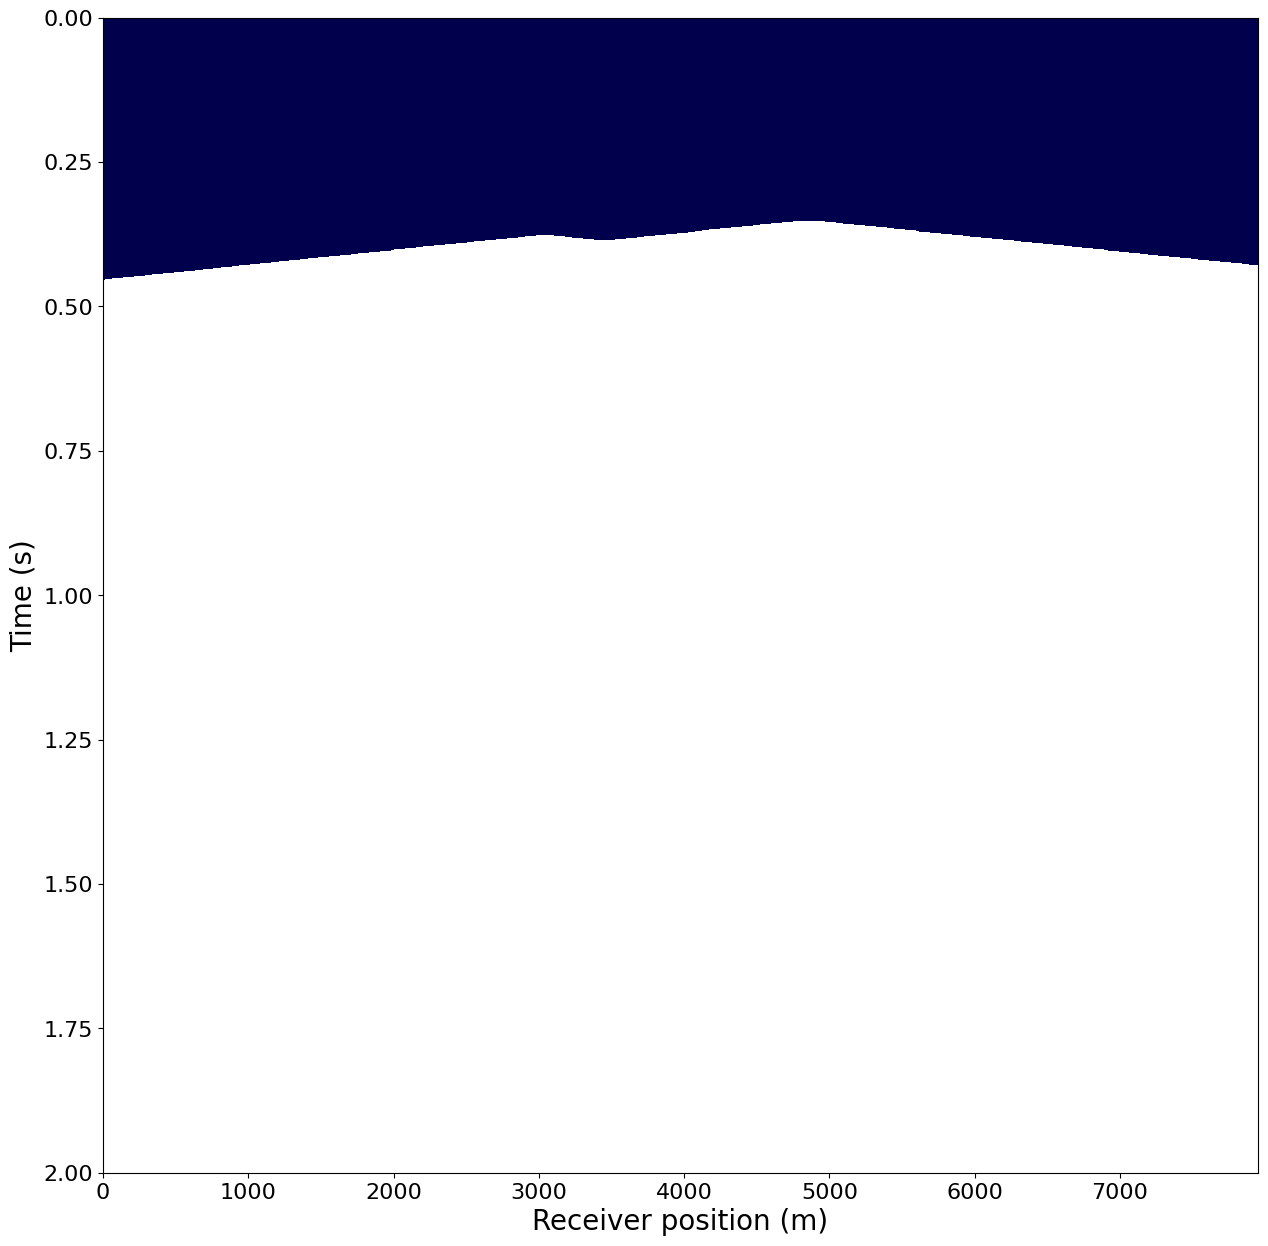

In [6]:
plot_seis_data(rec_coordinates=rec_coordinates,rec_data=rec2.data, t0=t0, tn=tn)